In [1]:
## This notebook is for comparing background subtraction methods and informing our pulse cadence
import os
workingdir='/home/tyndall/newburghlab-drone'
os.chdir(workingdir)

from dronehacks.GBO_Corr_Class import *
from dronehacks.Drone_Class import *
from dronehacks.CONCAT_Class import *

In [2]:
## Key, Position, Channel, Polarization, Pointing Variable Assignment:
## RECEIVER INFORMATION is needed to initialize the geometric environments: ##
## Must include some 'key' strings for labelling/identifying receivers: [Pranav's Conventions]
Array_Keys=["Dish_0","Dish_7","Dish_2","Dish_3","Dish_4","Dish_5","Dish_6","Dish_8"]
## Specify Coordinate Origin: #810m about MSL
GBO_HIRAX_DISH_0=pygeodesy.ellipsoidalNvector.LatLon(38.429280, -79.844990, 810).to3llh()
## Must Specify Coordinates and Pointings of receivers in Local Cartesian in an array of shape: n_receivers x 3 ##
Array_Coords=np.array([[0.0, 0.0, 0.0], # "Dish_0" \
                       [-24.215395745765452, -12.605737141316427, 0.0], # "Dish_7" \
                       [-8.403824760877617, 16.143597163843634, 0.0], # "Dish_2" \
                       [-8.071798581921817, -4.2019123804388085, 0.0], # "Dish_3" \
                       [-12.273710962360624, 3.869886201483008, 0.0], # "Dish_4" \
                       [-16.475623342799434, 11.941684783404824, 0.0], # "Dish_5" \
                       [-20.345509544282443, -0.33202617895580033, 0.0], # "Dish_6" \
                       [-28.41730812620426, -4.53393855939461, 0.0]]) # "Dish_8" \
## If pointings are defined by vectors in Local Coordinates (E,N,U) use:
Array_Pointings=np.array([[0,0,1], # +Z (up) in LC \
                          [0,0,1],\
                          [0,0,1],\
                          [0,0,1],\
                          [0,0,1],\
                          [0,0,1],\
                          [0,0,1],\
                          [0,0,1]])
## If pointings are defined by angles from zenith, use:
Array_Pointings=np.array([RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),  # e.g. 1 deg of yaw and roll \
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0])])
## Define Array Polarizations (2 per dish) in Local Cartesian E,N,U:
Array_Pols=np.array([[[1,0,0],[0,1,0]], # E,N \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]]])

## 8 DISH PLOTTING:
GBO8_chmap=np.array([0,1,3,2,4,5,7,6,9,8,10,11,12,13,14,15])
GBO8_automap=np.array([0,  16,  45,  31,  58,  70,  91,  81, 108, 100, 115, 121, 126, 130, 133, 135])

In [3]:
## Thursday 100m Pulsed Grid Flight w/ 16 Channels / 8 Dishes:

## Initialize correlator data class and pull auto correlations:
gaindir='/hirax/GBO_Data/TONE_ACQ/digital_gains/20210826T195003Z_yale_drone_yale_digitalgain/'
datadir='/hirax/GBO_Data/Emilys_Rsync/processed/20210826T195003Z_yale_drone/corr/20210826T195014Z/'

main_beam_corr=Corr_Data(n_channels=16,\
                              chmap=GBO8_chmap,\
                              Data_Directory=datadir,\
                              Working_Directory=workingdir,\
                                Data_File_Index=range(95), # last 2 files are worthless (power outage) \
                              Gain_Directory=gaindir)

Initializing Correlator Class using:
 --> /hirax/GBO_Data/Emilys_Rsync/processed/20210826T195003Z_yale_drone/corr/20210826T195014Z/
 --> Arrays initialized with shape (95, 256, 1023, 16)
Assigning array values by reading in data files:
 --> Loading File: 0094_processed/0096_processed

In [4]:
## Read Drone Data: 
drone_directory='/hirax/all_drone_data/datcon_csv/'
ndishes=8
main_beam_drone=Drone_Data(dronedir=drone_directory,\
                                FLYTAG='FLY536.csv',\
                                Origin_llh=GBO_HIRAX_DISH_0,\
                                Origin_key='Hirax_Dish_0',\
                                dkeys=Array_Keys[:ndishes],\
                                dcoords=Array_Coords[:ndishes],\
                                dpointings=Array_Pointings[:ndishes],\
                                dpols=Array_Pols[:ndishes])

Initializing drone data via datcon_csv routine: FLY536.csv
 --> Skipping rows 1 to 499 to eliminate NAN values
Timestamp interpolation succeeded
 --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
 --> generating dish and receiver line of sight coordinates.


In [5]:
## Initialize CONCAT class and interpolate drone coords:
mainbeamconcat=CONCAT(CORRDATCLASS=main_beam_corr,DRONEDATCLASS=main_beam_drone)

Initializing CONCAT CLASS using:
 --> /hirax/GBO_Data/Emilys_Rsync/processed/20210826T195003Z_yale_drone/corr/20210826T195014Z/
 --> FLY536.csv
Interpolating drone coordinates for each correlator timestamp:
  --> correlator timestamp axis contains 23980 elements
  --> drone timestamp axis contains 12842 elements


/home/tyndall/newburghlab-drone/dronehacks/CONCAT_Class.py:101: RuntimeWarning: invalid value encountered in true_divide
  normminsubdata=minsubdata/np.nanmax(minsubdata)
/home/tyndall/newburghlab-drone/dronehacks/CONCAT_Class.py:112: RuntimeWarning: All-NaN slice encountered
  maxPrind=np.where(Pr_arr[i,:]==np.nanmax(Pr_arr[i,:]))[0][0]


Maximum Pearson_R Correlations:
  --> t_indices = [466. 480. 501. 473. 464. 480.  23. 479. 465. 480. 464. 481. 481.  nan
 501. 473.]
  --> t_offsets = [-0.21341341 -0.20780781 -0.1993994  -0.21061061 -0.21421421 -0.20780781
 -0.39079079 -0.20820821 -0.21381381 -0.20780781 -0.21421421 -0.20740741
 -0.20740741         nan -0.1993994  -0.21061061]
Selecting global time offset:
  --> global_t_offset = -0.1872082082
Finding relevant pulsing indices and checking for overlaps:
  --> on/off ind intersection: []
  --> on/span ind intersection: []
  --> off/span ind intersection: []


/home/tyndall/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/home/tyndall/newburghlab-drone/dronehacks/CONCAT_Class.py:149: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.semilogy(self.t_arr_datetime[:],self.V[:,f_ind,i],'k.',label='all')
/home/tyndall/newburghlab-drone/dronehacks/CONCAT_Class.py:150: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.semilogy(self.t_arr_datetime[self.inds_on],self.V[self.inds_on,f_ind,i],'.',label='on')
/home/tyndall/newburghlab-drone/dronehacks/CONC

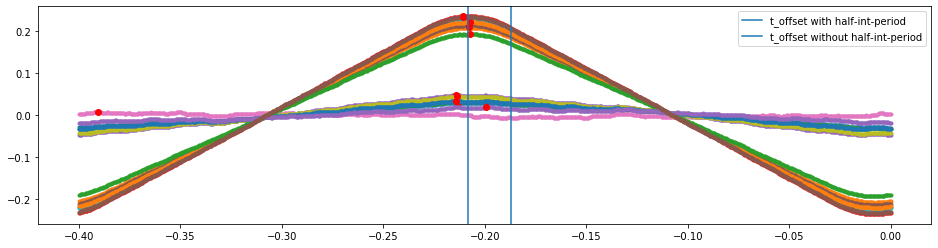

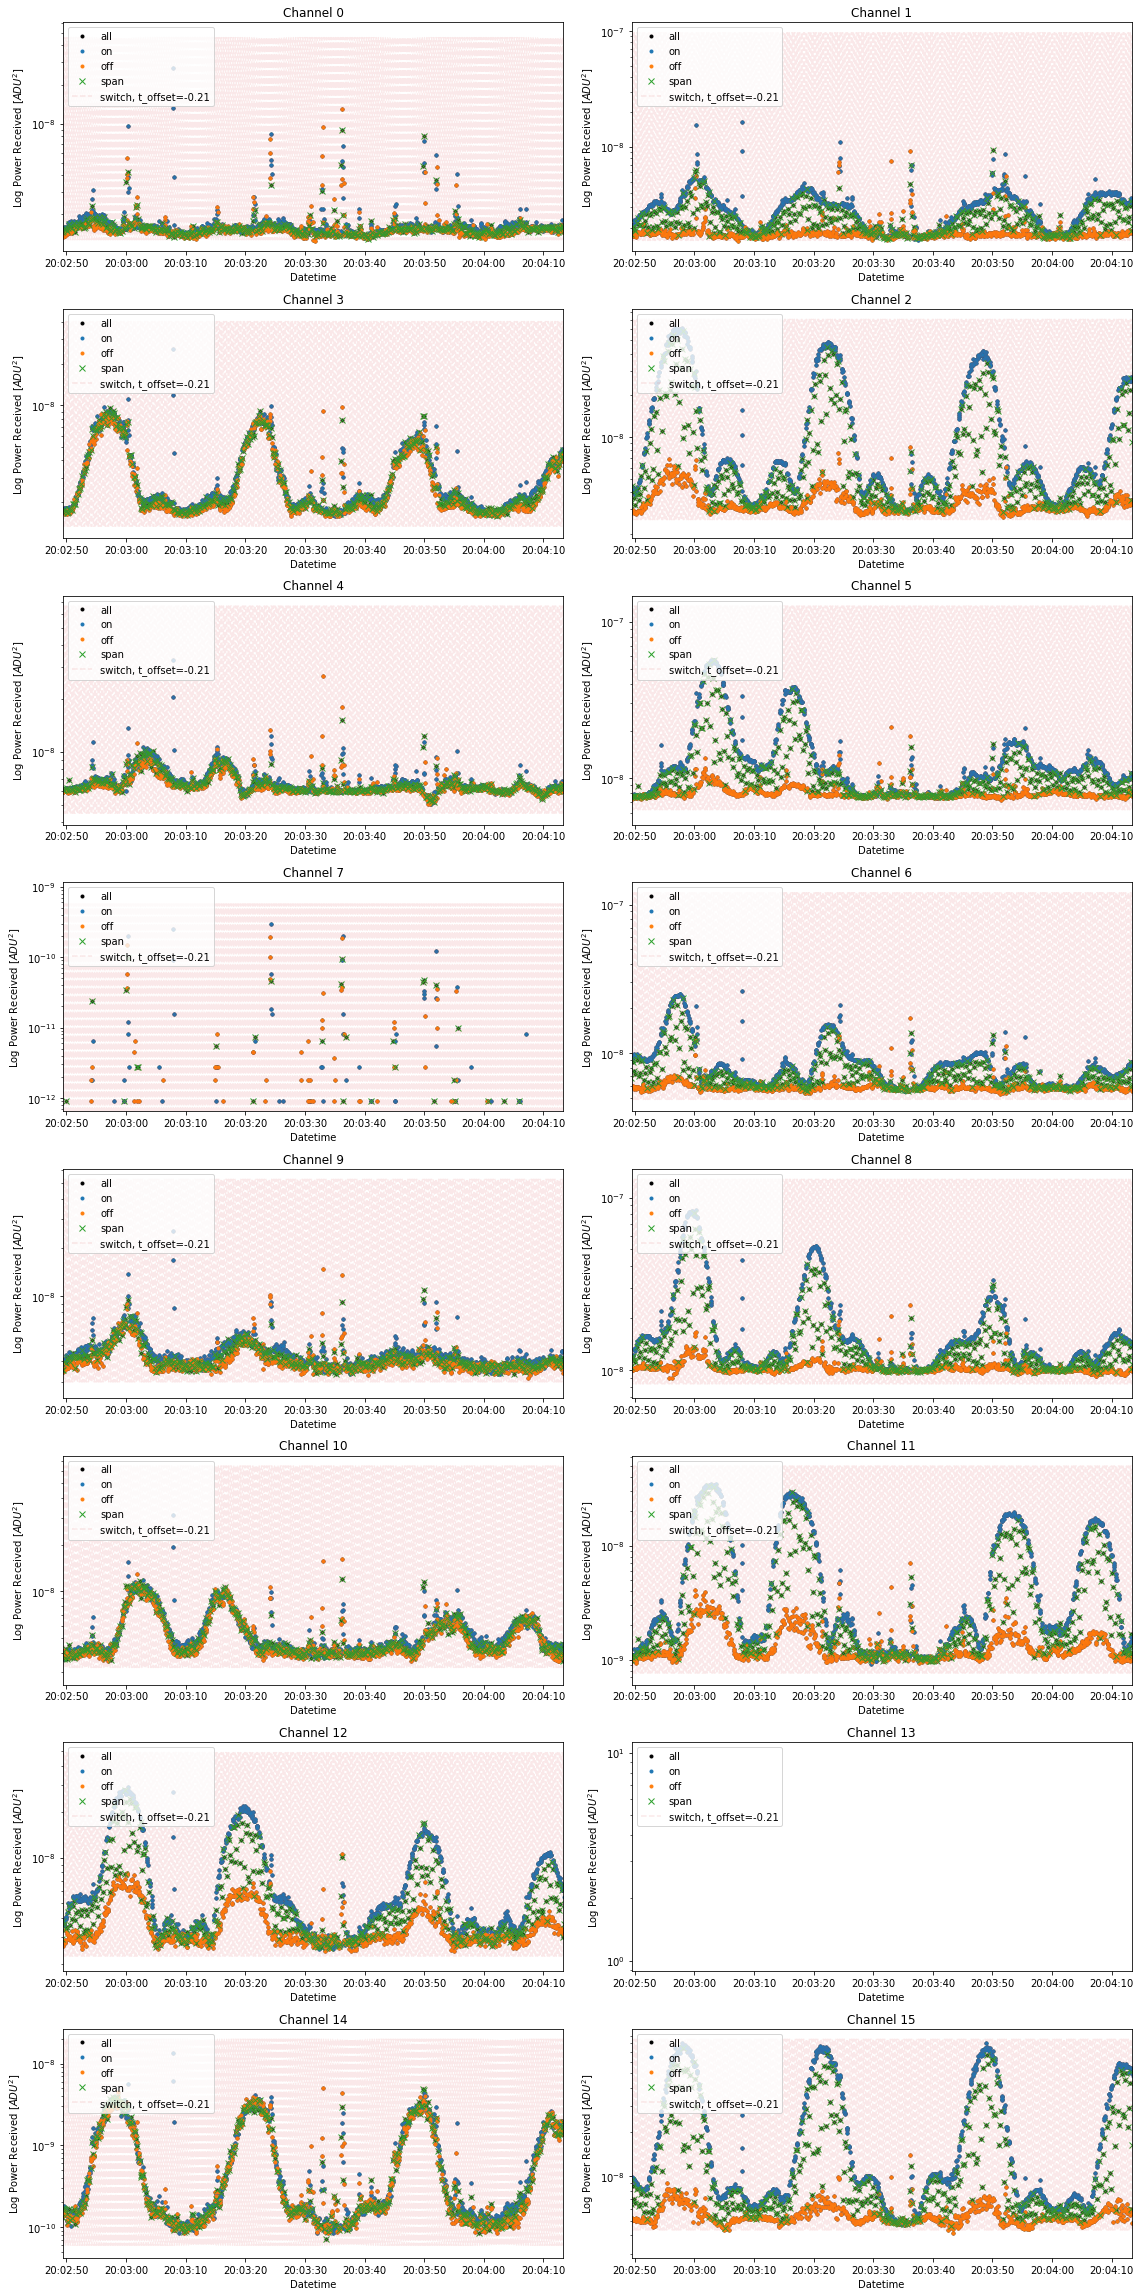

In [6]:
## Find the pulsed source signal: (comment out if source was broadcast continuously)
mainbeamconcat.Extract_Source_Pulses(Period=0.4e6,\
                                       Dutycycle=0.2e6,\
                                       t_bounds=[18000,20000],\
                                       f_ind=[910],\
                                       half_int_period=0.021)

In [7]:
mainbeamconcat.Perform_Background_Subtraction()

/home/tyndall/newburghlab-drone/dronehacks/CONCAT_Class.py:175: RuntimeWarning: Mean of empty slice
  self.V_bg[k,:,:]=np.nanmean(self.V[t_window,:,:],axis=0)


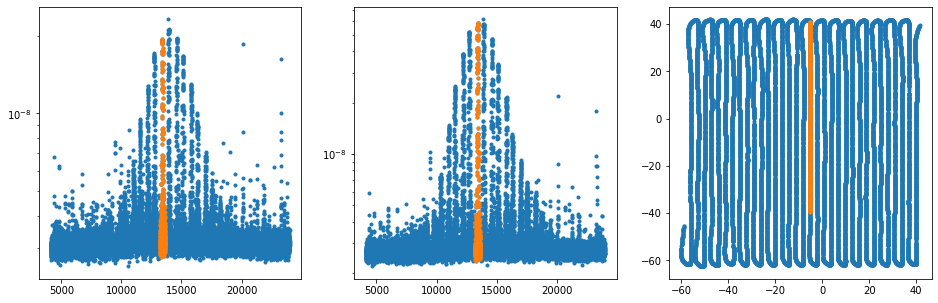

In [30]:
fig1,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,5))
tlb,tub=[0,-1]
tlb,tub=[4125,24000]
ax1.semilogy(mainbeamconcat.t_index[tlb:tub],mainbeamconcat.V[tlb:tub,400,0],'.')
ax2.semilogy(mainbeamconcat.t_index[tlb:tub],mainbeamconcat.V[tlb:tub,400,1],'.')
ax3.plot(mainbeamconcat.drone_xyz_LC_interp[tlb:tub,0],mainbeamconcat.drone_xyz_LC_interp[tlb:tub,1],'.')
tlb,tub=[13200,13650]
ax1.semilogy(mainbeamconcat.t_index[tlb:tub],mainbeamconcat.V[tlb:tub,400,0],'.')
ax2.semilogy(mainbeamconcat.t_index[tlb:tub],mainbeamconcat.V[tlb:tub,400,1],'.')
ax3.plot(mainbeamconcat.drone_xyz_LC_interp[tlb:tub,0],mainbeamconcat.drone_xyz_LC_interp[tlb:tub,1],'.')

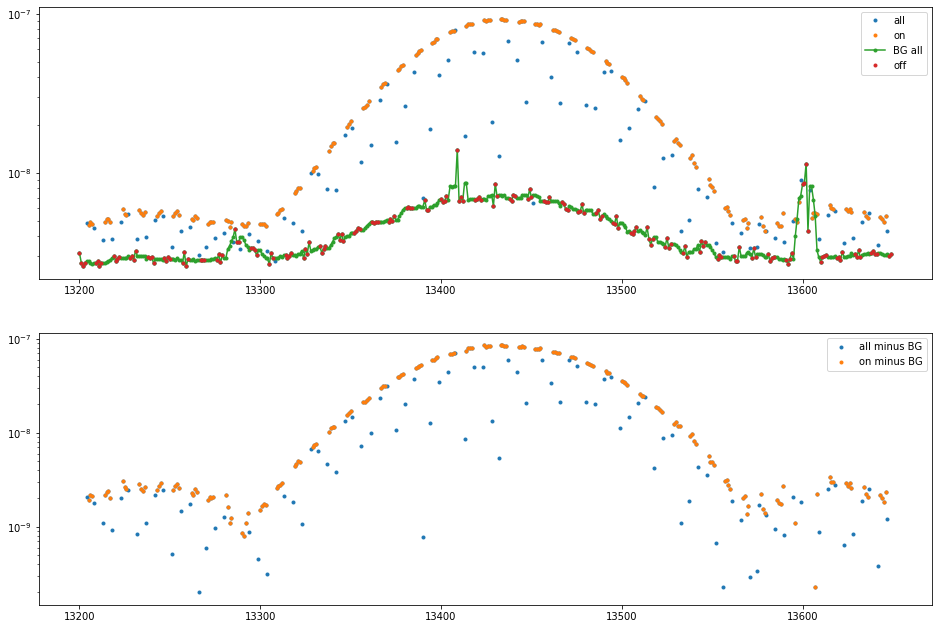

In [31]:
fig1,[ax1,ax2]=subplots(nrows=2,ncols=1,figsize=(16,11))
for i,ax in enumerate([ax1]):
    i=1
    tfull=np.arange(tlb,tub)
    tcuton=np.intersect1d(np.arange(tlb,tub),mainbeamconcat.inds_on).tolist()
    tcutoff=np.intersect1d(np.arange(tlb,tub),mainbeamconcat.inds_off).tolist()
    ax.semilogy(tfull,mainbeamconcat.V[tfull,900,i],'.',label='all')
    ax.semilogy(tcuton,mainbeamconcat.V[tcuton,900,i],'.',label='on')
    ax.semilogy(tfull,mainbeamconcat.V_bg[tfull,900,i],'.-',label='BG all')
    ax.semilogy(tcutoff,mainbeamconcat.V[tcutoff,900,i],'.',label='off')
    ax.legend()
    
for i,ax in enumerate([ax2]):
    i=1
    ax.semilogy(tfull,mainbeamconcat.V_bgsub[tfull,900,i],'.',label='all minus BG')
    ax.semilogy(tcuton,mainbeamconcat.V_bgsub[tcuton,900,i],'.',label='on minus BG')
    ax.legend()

[4.37957108e-09 1.34290346e+04 4.62895414e+01 3.17864572e-09]
[4.66796107e-09 1.34277360e+04 4.64690591e+01 3.07980080e-09]


(5e-10, 1e-07)

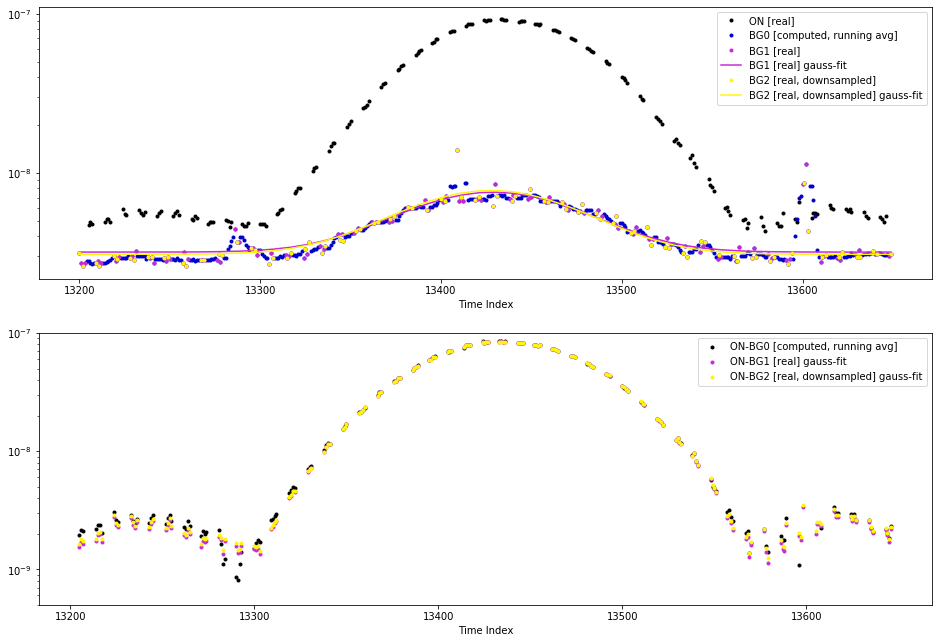

In [40]:
fig1,[ax1,ax2]=subplots(nrows=2,ncols=1,figsize=(16,11))
for i,ax in enumerate([ax1]):
    i=1
    tfull=np.arange(tlb,tub)
    tcuton=np.intersect1d(np.arange(tlb,tub),mainbeamconcat.inds_on).tolist()
    tcutoff=np.intersect1d(np.arange(tlb,tub),mainbeamconcat.inds_off).tolist()

    ax1.semilogy(tcuton,mainbeamconcat.V[tcuton,900,i],'.',c=colorsarr[0],label='ON [real]')
    ax1.semilogy(tfull,mainbeamconcat.V_bg[tfull,900,i],'.',c=colorsarr[2],label='BG0 [computed, running avg]')
    ax2.semilogy(tcuton,mainbeamconcat.V_bgsub[tcuton,900,i],'.',c=colorsarr[0],label='ON-BG0 [computed, running avg]')

    #ax.semilogy(tcutoff,mainbeamconcat.V[tcutoff,900,i],'.',label='off data')

    
    ## GAUSS FIT to create the BG and subtract it?
    theta=tcutoff
    dat=mainbeamconcat.V[tcutoff,900,i]
    a0=np.nanmax(dat)
    thetaoff0=np.nanmean(theta)
    sigma0=30
    bg0=np.nanmin(dat)
    p0=[a0,thetaoff0,sigma0,bg0]
    popt,pcov=curve_fit(Gauss,theta,dat,p0=p0)
    print(popt)
    ax.semilogy(tcutoff,mainbeamconcat.V[tcutoff,900,i],'.',c=colorsarr[5],label='BG1 [real]')
    ax.semilogy(tcutoff,Gauss(tcutoff,*popt),c=colorsarr[5],label="BG1 [real] gauss-fit")
    ax2.semilogy(tcuton,mainbeamconcat.V[tcuton,900,i]-Gauss(tcuton,*popt),'.',c=colorsarr[5],label='ON-BG1 [real] gauss-fit')
    ## GAUSS FIT (with HALF the original BG points) to create the BG and subtract it?
    theta=tcutoff[::2]
    dat=mainbeamconcat.V[tcutoff[::2],900,i]
    a0=np.nanmax(dat)
    thetaoff0=np.nanmean(theta)
    sigma0=30
    bg0=np.nanmin(dat)
    p0=[a0,thetaoff0,sigma0,bg0]
    popt,pcov=curve_fit(Gauss,theta,dat,p0=p0)
    print(popt)
    ax.semilogy(tcutoff[::2],mainbeamconcat.V[tcutoff[::2],900,i],'.',c=colorsarr[9],label='BG2 [real, downsampled]')
    ax.semilogy(tcutoff,Gauss(tcutoff,*popt),c=colorsarr[9],label="BG2 [real, downsampled] gauss-fit")
    ax2.semilogy(tcuton,mainbeamconcat.V[tcuton,900,i]-Gauss(tcuton,*popt),'.',c=colorsarr[9],label='ON-BG2 [real, downsampled] gauss-fit')
    
    
for i,ax in enumerate([ax2]):
    i=1
    #ax.semilogy(tfull,mainbeamconcat.V_bgsub[tfull,900,i],'.',label='mean bg')

for i,ax in enumerate([ax1,ax2]):
    ax.legend()
    ax.set_xlabel("Time Index")
    
ax2.set_ylim(5e-10,1e-7)

